In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from utils import data_utils as du, feature_utils as fu, plot_utils as pu

# Load Data

In [2]:
exchange = "binance"

start_date = "20230101"
end_date = "20241231"

start_dt = dt.datetime.strptime(start_date, "%Y%m%d")
end_dt = dt.datetime.strptime(end_date, "%Y%m%d")

In [3]:
level1_data = du.get_files(start_dt, end_dt, "level1", exchange, "futures", "BTCUSDT")
book_data = du.get_files(start_dt, end_dt, "book", exchange, "futures", "BTCUSDT")
trade_data = du.get_files(start_dt, end_dt, "trade", exchange, "futures", "BTCUSDT")

level1_data.shape, book_data.shape, trade_data.shape

((1052640, 28), (1052640, 63), (1052640, 23))

In [4]:
# Convert timestamps to datetime
level1_data['ts_end'] = pd.to_datetime(level1_data['ts_end'], unit='ms')
book_data[['ts_end', 'ts_book']] = book_data[['ts_end', 'ts_book']].apply(pd.to_datetime, unit='ms')
trade_data['ts_end'] = pd.to_datetime(trade_data['ts_end'], unit='ms')

# Set index to ts_end
level1_data.set_index('ts_end', inplace=True)
book_data.set_index('ts_end', inplace=True)
trade_data.set_index('ts_end', inplace=True)

# Align time series data
(level1_data, book_data, trade_data), start, end = du.align_ts(level1_data, book_data, trade_data)

# Create a common time index
time_idx = pd.date_range(start=start, end=end, freq='1min')

time_idx[[0, -1]]

DatetimeIndex(['2023-01-01 00:01:00', '2024-12-31 23:59:00'], dtype='datetime64[ns]', freq=None)

In [5]:
# Compute log return
level1_data['log_return'] = np.log(level1_data['close_mid'] / level1_data['close_mid'].shift(1))

In [6]:
level1_data.columns

Index(['bin_id', 'carryover', 'ramp_up', 'tick_count', 'l3_updates',
       'open_mid', 'first_mid', 'close_mid', 'min_mid', 'max_mid', 'close_bid',
       'close_ask', 'close_bid_size', 'close_ask_size', 'max_bid', 'min_ask',
       'ask_up_ret', 'ask_down_ret', 'bid_up_ret', 'bid_down_ret',
       'median_spread', 'mean_spread', 'min_spread', 'max_spread',
       'mean_bid_size', 'mean_ask_size', 'tick_volatility', 'log_return'],
      dtype='object')

In [7]:
trade_data.columns

Index(['bin_id', 'carryover', 'ramp_up', 'trade_count', 'buy_trade_count',
       'sell_trade_count', 'taker_trade_count', 'taker_buy_trade_count',
       'taker_sell_trade_count', 'open_price', 'first_price', 'close_price',
       'min_price', 'max_price', 'median_price', 'volume', 'buy_volume',
       'sell_volume', 'vwap', 'buy_vwap', 'sell_vwap', 'trade_volatility'],
      dtype='object')

# Features

#### Level1 Features

In [8]:
taus = [1, 5, 15, 30, 60]
feature_level1_df = fu.feature_level1(time_idx, level1_data, taus)
feature_level1_df.tail()

,log_ret_1m,log_ret_5m,log_ret_15m,log_ret_30m,log_ret_60m,abs_ret_1m,abs_ret_5m,abs_ret_15m,abs_ret_30m,abs_ret_60m,...,spread_mean,spread_median,spread_min,spread_max,spread_mean_norm,spread_median_norm,spread_min_norm,spread_max_norm,log_spread_mean_norm,log_spread_median_norm
2024-12-31 23:55:00,-0.000195,0.001075,0.001974,0.000179,0.001293,0.000195,0.001075,0.001974,0.000179,0.001293,...,0.533987,0.1,0.1,6.5,0.000006,0.000001,0.000001,0.000069,0.000006,0.000001
2024-12-31 23:56:00,0.000270,0.000669,0.002396,0.000500,0.001450,0.000270,0.000669,0.002396,0.000500,0.001450,...,0.577692,0.1,0.1,5.6,0.000006,0.000001,0.000001,0.000060,0.000006,0.000001
2024-12-31 23:57:00,-0.000425,-0.000425,0.001477,-0.000932,0.001668,0.000425,0.000425,0.001477,0.000932,0.001668,...,0.612829,0.2,0.1,11.5,0.000007,0.000002,0.000001,0.000123,0.000007,0.000002
2024-12-31 23:58:00,-0.000265,-0.000940,0.001383,-0.001241,0.001598,0.000265,0.000940,0.001383,0.001241,0.001598,...,0.483636,0.1,0.1,3.3,0.000005,0.000001,0.000001,0.000035,0.000005,0.000001
2024-12-31 23:59:00,-0.000155,-0.000770,0.001436,-0.001345,0.001532,0.000155,0.000770,0.001436,0.001345,0.001532,...,0.736752,0.1,0.1,12.8,0.000008,0.000001,0.000001,0.000137,0.000008,0.000001


#### Book Features

In [9]:
feature_book_df = fu.feature_book(time_idx, book_data)
feature_book_df.tail()

,obi,obi_1bps,obi_3bps,obi_10bps,obi_30bps,obi_100bps,ofi,ofi_1bps,ofi_3bps,ofi_10bps,ofi_30bps,ofi_100bps
2024-12-31 23:55:00,-0.033011,-0.739488,-0.343992,-0.093641,-0.042683,-0.042683,30.452055,-2.716439,0.371663,-18.270748,2.569667,2.569667
2024-12-31 23:56:00,-0.985821,-0.661873,-0.198578,-0.142965,-0.038889,-0.038889,0.293346,-0.804979,-0.807130,0.462147,-0.074233,-0.074233
2024-12-31 23:57:00,0.071460,0.055490,0.020008,0.045420,0.024329,0.024329,0.823500,-1.134595,-8.728578,-3.110297,3.375156,3.375156
2024-12-31 23:58:00,-0.598751,-0.570515,0.007376,0.096679,0.011856,0.011856,1.696266,-1.324837,0.332187,3.356803,0.299030,0.299030
2024-12-31 23:59:00,0.638357,0.665453,0.210867,0.286810,0.122075,0.122075,3.557957,-8.920767,8.799315,11.463836,-47.880911,-47.880911


#### Trade Features

In [10]:
taus = [1, 5, 15, 30, 60]
feature_trade_df = fu.feature_trade(time_idx, trade_data, taus)
feature_trade_df.tail()

,trade_vol,trade_count,trade_vol_ema_1m,trade_vol_ema_5m,trade_vol_ema_15m,trade_vol_ema_30m,trade_vol_ema_60m,buy_trade_count,sell_trade_count,taker_trade_count,...,buy_volume_ema_1m,buy_volume_ema_5m,buy_volume_ema_15m,buy_volume_ema_30m,buy_volume_ema_60m,sell_volume_ema_1m,sell_volume_ema_5m,sell_volume_ema_15m,sell_volume_ema_30m,sell_volume_ema_60m
2024-12-31 23:55:00,0.136762,777,0.136762,0.133570,0.137157,0.139700,0.143085,141,243,263,...,14.680,26.735441,27.840842,26.440307,26.360099,19.146,19.355794,20.635204,22.078277,23.708339
2024-12-31 23:56:00,0.079687,803,0.079687,0.115609,0.129974,0.135828,0.141007,246,112,261,...,52.699,35.389961,30.948112,28.134417,27.223669,12.842,17.184529,19.661054,21.482388,23.352065
2024-12-31 23:57:00,0.122685,1018,0.122685,0.117968,0.129063,0.134980,0.140406,210,350,326,...,8.748,26.509307,28.173098,26.883680,26.617909,16.032,16.800353,19.207422,21.130750,23.112063
2024-12-31 23:58:00,0.055708,661,0.055708,0.097215,0.119893,0.129866,0.137629,86,194,215,...,4.814,19.277538,25.253211,25.459830,25.903027,12.673,15.424569,18.390619,20.585089,22.769799
2024-12-31 23:59:00,0.159267,714,0.159267,0.117899,0.124815,0.131763,0.138338,84,234,224,...,5.755,14.770025,22.815934,24.188550,25.242436,12.175,14.341379,17.613667,20.042503,22.422428


#### Other Features

In [11]:
feature_others_df = fu.feature_others(time_idx)
feature_others_df.tail()

,hour,sin_hour,cos_hour,minute,sin_minute,cos_minute,day_of_week,sin_dow,cos_dow,is_weekend,is_dst,is_hour_start,is_hour_end
2024-12-31 23:55:00,23,-0.258819,0.965926,55,-0.500000,0.866025,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:56:00,23,-0.258819,0.965926,56,-0.406737,0.913545,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:57:00,23,-0.258819,0.965926,57,-0.309017,0.951057,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:58:00,23,-0.258819,0.965926,58,-0.207912,0.978148,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:59:00,23,-0.258819,0.965926,59,-0.104528,0.994522,1,0.781831,0.62349,0,0,0,1


# Target

In [12]:
target_rv_df = fu.target_rv(time_idx, level1_data, horizons=[60])
target_rv_df.head()

,target_rv_fwd60m
2023-01-01 00:01:00,0.158508
2023-01-01 00:02:00,0.158838
2023-01-01 00:03:00,0.159852
2023-01-01 00:04:00,0.157915
2023-01-01 00:05:00,0.158012


# Correlation

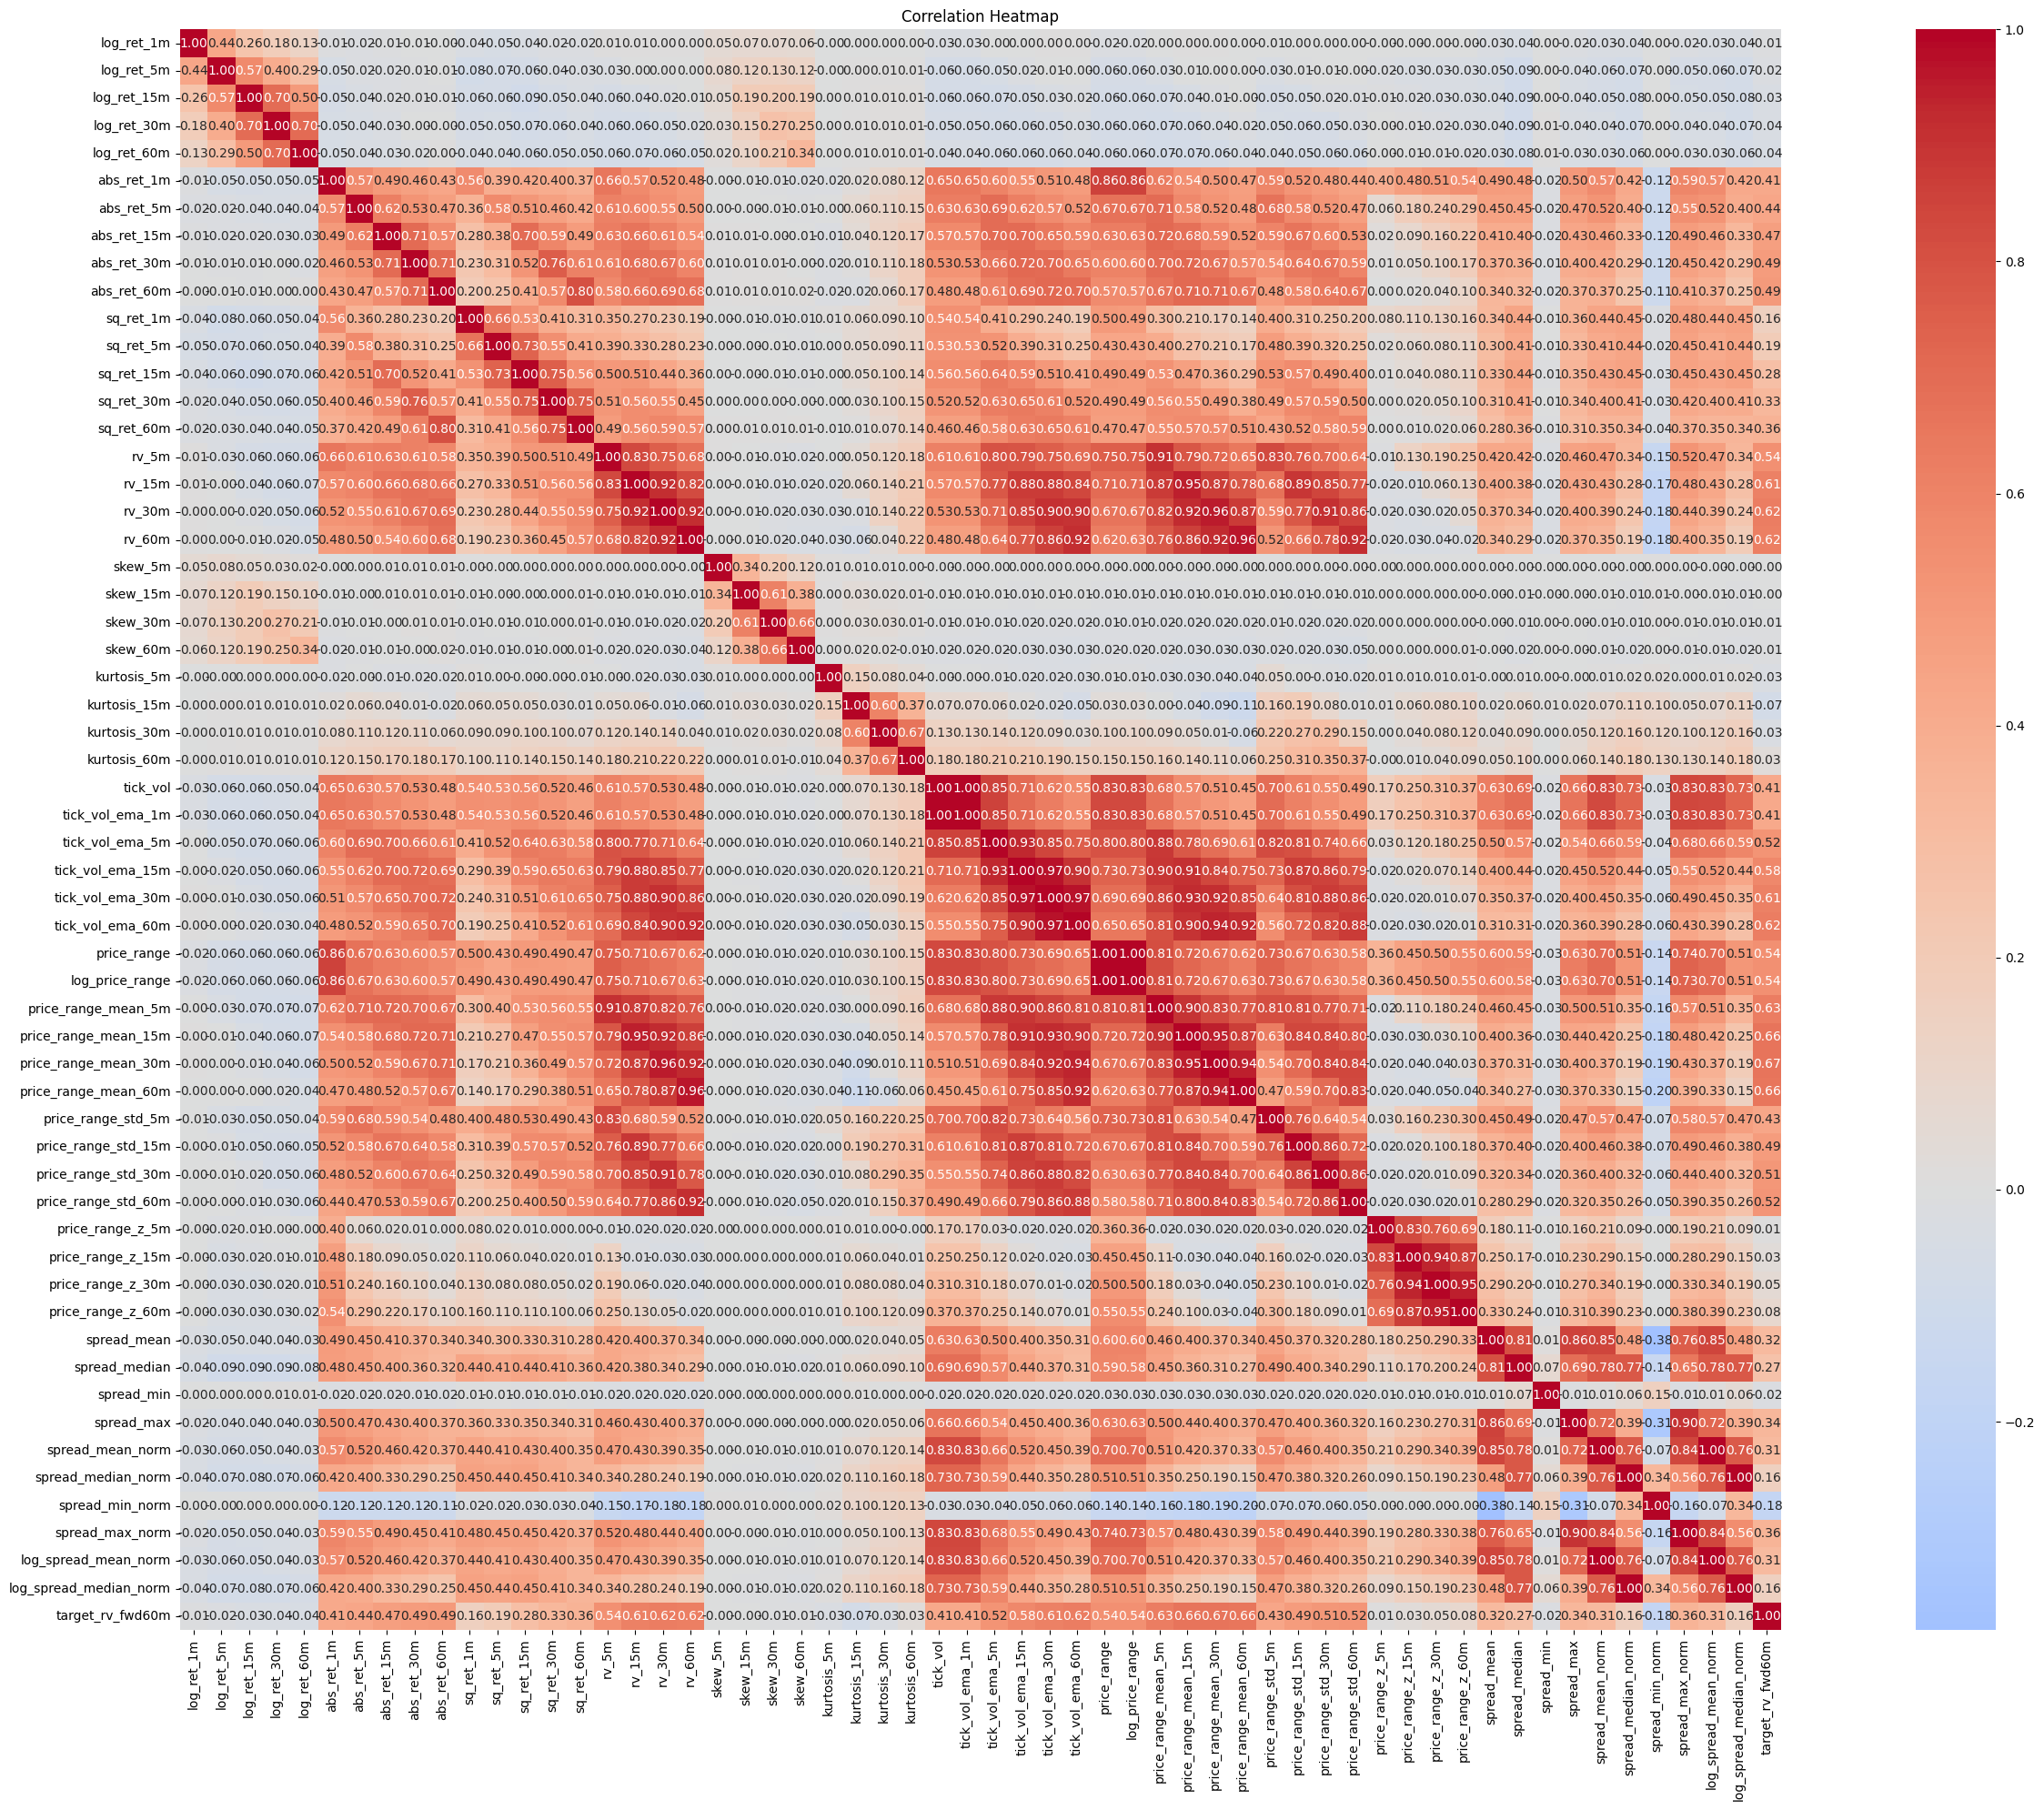

In [13]:
df_corr = pd.concat(
    [feature_level1_df, target_rv_df],
    axis=1
)

pu.plot_corr_heatmap(df_corr, figsize=(30,20))

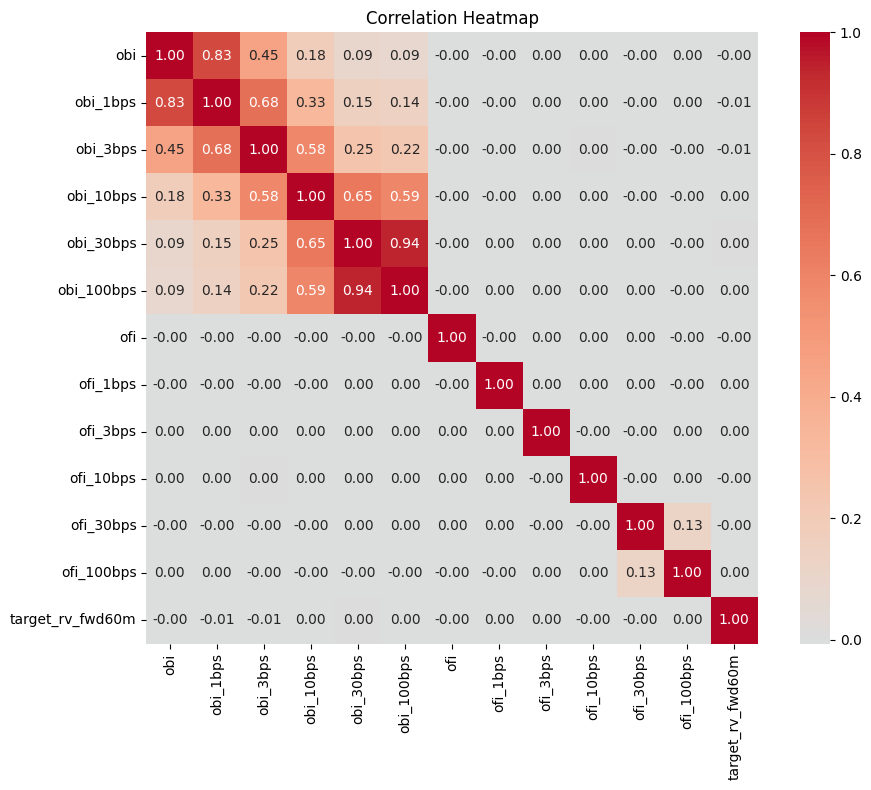

In [14]:
df_corr = pd.concat(
    [feature_book_df, target_rv_df],
    axis=1
)

pu.plot_corr_heatmap(df_corr)

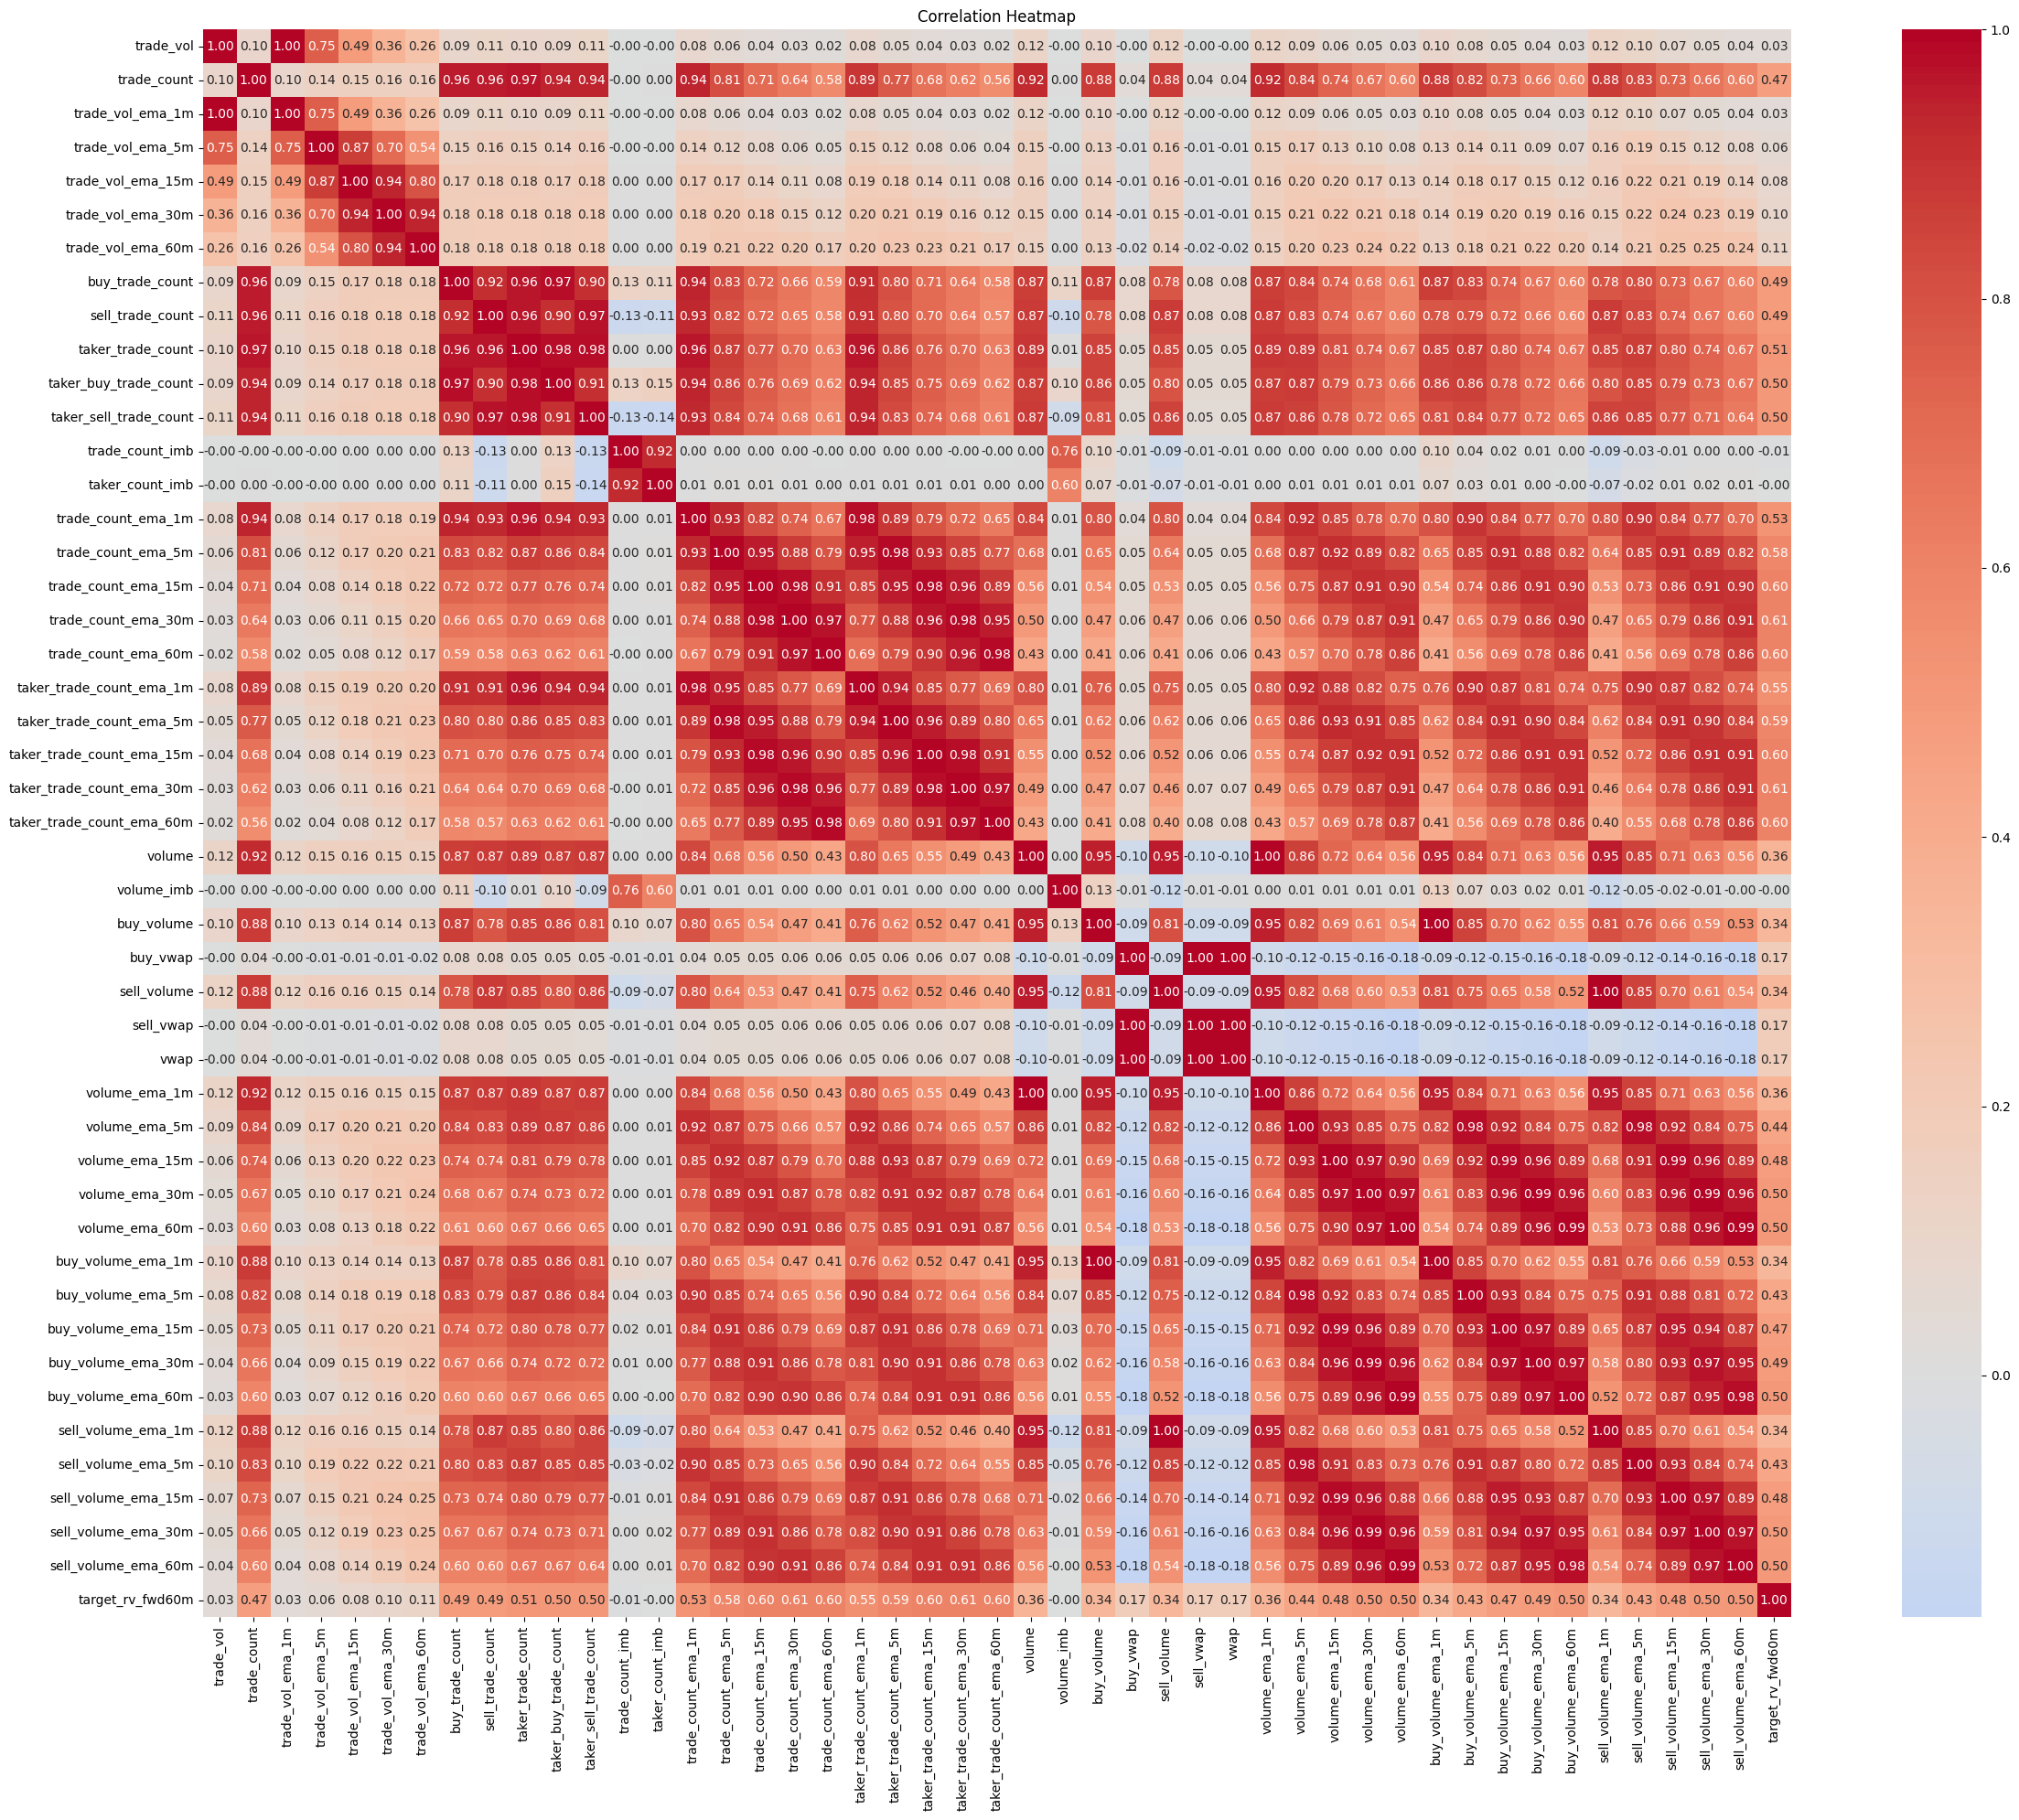

In [17]:
df_corr = pd.concat(
    [feature_trade_df, target_rv_df],
    axis=1
)

pu.plot_corr_heatmap(df_corr, figsize=(26,20))

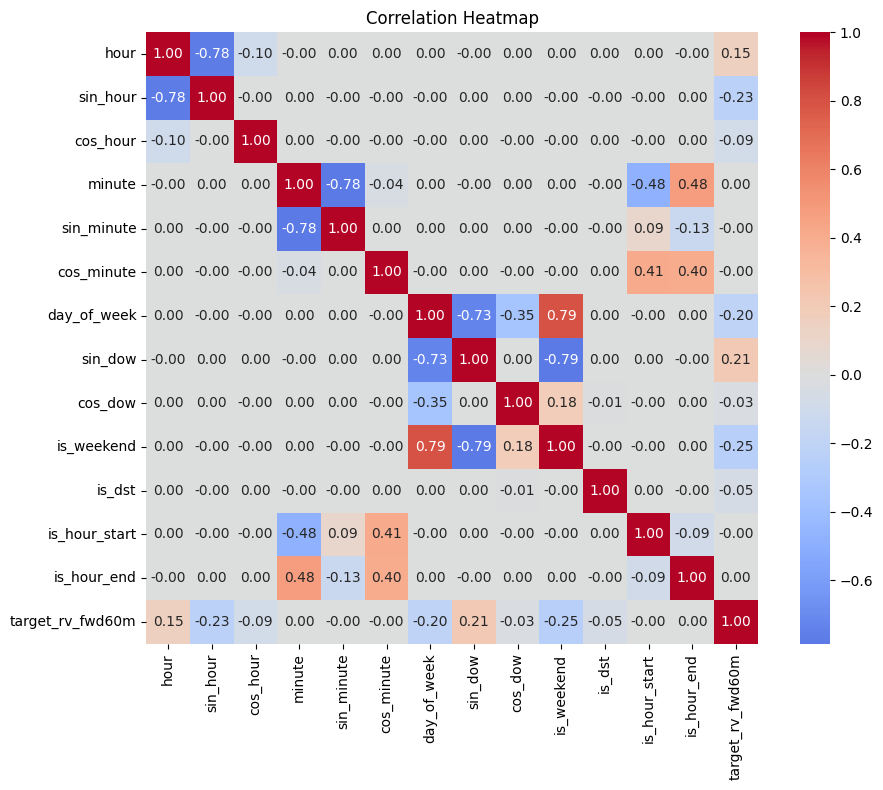

In [16]:
df_corr = pd.concat(
    [feature_others_df, target_rv_df],
    axis=1
)

pu.plot_corr_heatmap(df_corr)